# VIP - Vortex Image Processing package

Tutorial for VIP version *0.9.4*

Author: *Carlos Alberto Gomez Gonzalez*

Date: *2018/03/15*

## Table of contents

* [1. Loading ADI data](#1.-Loading-ADI-data)

* [2. Pre-processing the ADI cube](#2.-Pre-processing-the-ADI-cube)
    - [2.1. Re-centering the ADI frames](#2.1.-Re-centering-the-ADI-frames)
    - [2.2. Additional pre-processing procedures](#2.2.-Additional-pre-processing-procedures)

* [3. Signal to noise and S/N map generation](#3.-Signal-to-noise-and-S/N-map-generation)

* [4. Model PSF subtraction for ADI](#4.-Model-PSF-subtraction-for-ADI)
    - [4.1. ADI median subtraction](#4.1.-ADI-median-subtraction)
    - [4.2. Pairwise frame differencing](#4.2.-Pairwise-frame-differencing)
    - [4.3. Least-squares approximation](#4.3.-Least-squares-approximation)
    - [4.4. Full-frame PCA](#4.4.-Full-frame-PCA)
        - [4.4.1. Optimizing the number of PCs for full-frame ADI PCA](#4.4.1.-Optimizing-the-number-of-PCs-for-full-frame-ADI-PCA)
        - [4.4.2. Full-frame ADI PCA with a PA rejection criterion](#4.4.2.-Full-frame-ADI-PCA-with-a-PA-rejection-criterion)
        - [4.4.3. PCA for big datacubes](#4.4.3.-PCA-for-big-datacubes)
    - [4.5. Annular PCA](#4.4.-Annular-PCA)
    - [4.6. Full-frame NMF](#4.5.-Full-frame-ADI-NMF)
    - [4.7. LLSG](#4.7.-LLSG)
    - [4.8. Mosaic with the ADI model PSF subtraction techniques so far](#4.8.-Mosaic-with-the-ADI-model-PSF-subtraction-techniques-so-far)
 
* [5. Detection function](#5.-Detection-function)
 
* [6. Generating synthetic planets](#6.-Generating-synthetic-planets)
 
* [7. Flux and position estimation with the NEGFC](#7.-Flux-and-position-estimation-with-the-NEGFC)
    - [7.1. Nelder-Mead based optimization](#7.1.-Nelder-Mead-based-optimization)
    - [7.2. Planet subtraction](#7.2.-Planet-subtraction)
    - [7.3. NEGFC technique coupled with MCMC](#7.3.-NEGFC-technique-coupled-with-MCMC)
        - [7.3.1. Visualizing the MCMC chain: corner plots and walk plots](#7.3.1.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [7.3.2. Highly probable values and confidence intervals](#7.3.2.-Highly-probable-values-and-confidence-intervals)

* [8. Algorithmic throughput](#8.-Algorithmic-throughput)

* [9. Contrast curve generation for ADI](#9.-Contrast-curve-generation-for-ADI)


-----------

Assuming ``VIP`` is properly installed (check out the documentation webpage), we import it along with other useful libraries:

In [1]:
%matplotlib inline
from matplotlib.pyplot import *
import numpy as np

import vip_hci as vip
plots = vip.var.pp_subplots

In [273]:
vip.__version__

'0.9.4'

The alias ``plots`` points to a plotting function included in `VIP` (`vip_hci.var.pp_subplots`) which is a wrapper of matplotlib functions for easy plotting and visualization of 2d and 3d arrays. `VIP` also allows working with `DS9` provided that it's installed on your system along with ``pyds9`` (again, see ``VIP``'s documentation). A `DS9` session (window) can be started with: 

Then the *ds9* methods will allow interact with the `DS9` window. For example, for sending an in-memory array to the `DS9` window you can use:

# 1. Loading ADI data

In the same folder where this notebook is located you can find a toy ADI (Angular Differential Imaging) cube and a NACO PSF to demostrate the capabilities of ``VIP``. This is a L-band NACO coronagraphic (VORTEX AGPM) dataset of beta Pictoris. The sequence is heavily sub-sampled temporarily to make it smaller. Also the frames were cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

Let's inspect the fits file:

In [2]:
vip.fits.info_fits('./naco_betapic.fits')

Filename: ./naco_betapic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (101, 101, 61)   float32   
  1                1 ImageHDU         7   (1, 61)   float64   


It contains a cube and its correspoding parallactic angles. An ADI sequence is acquired in pupil tracking mode, which means that the instrument field derotator remains off, thereby keeping the instrument and telescope optics aligned while the image rotates with time.


Now we load the data "in" memory with the functions below:

In [3]:
psfnaco = './naco_psf.fits'
cube = './naco_betapic.fits'

cube_orig, angs = vip.fits.open_adicube(cube)
psf = vip.fits.open_fits(psfnaco)


Fits HDU:0 data successfully loaded. Data shape: [61,101,101]

Fits HDU:1 data successfully loaded. Data shape: [61]

Fits HDU:0 data successfully loaded. Data shape: [39,39]


The file is opened using `astropy` functionlity. The fits file is now a ndarray or ``numpy`` array on memory. If you open the file (or send it to the `DS9` window) and adjust the cuts you will see the beta Pic b planet movin in a circular trajectory.

Let's measure the FWHM by fitting a 2d Gaussian to the core of the PSF:

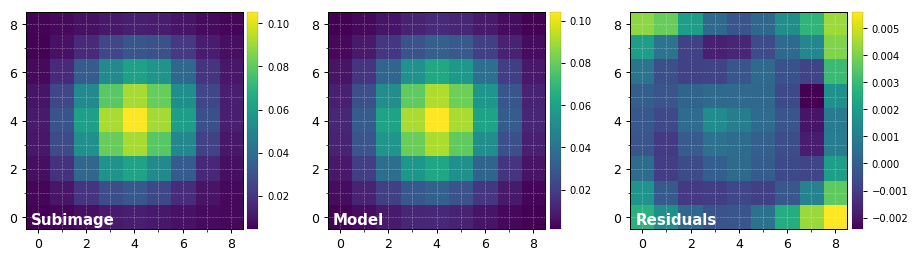

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

peak = 0.10413004853269707
theta = -0.5949065892468413


In [4]:
_ = vip.var.fit_2dgaussian(psf, crop=True, cropsize=9, debug=True)

In [5]:
fwhm_naco = np.mean([4.73, 4.47])
print(fwhm_naco)

4.6


Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [6]:
psfn = vip.phot.psf_norm(psf, fwhm_naco, size=19)

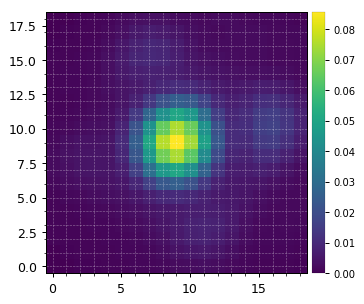

In [7]:
plots(psfn, grid=True)

Let's finally define the pixel-scale for NACO (L band), which we get from a dictionaries stored in the `conf` subpackage:

In [8]:
pxscale_naco = vip.conf.VLT_NACO['plsc']
print(pxscale_naco)

0.02719


[Go to the top](#Table-of-contents)

# 2. Pre-processing the ADI cube

The subpackage ``preproc`` contains all sort of low-level image transformation routines: translation, rotation, cropping, pixel resamplling. It also contains functions dedicated for processing 3D or 4D arrays. In this tutorial we'll focuse on ADI sequences, which come in the form of 3D arrays.

## 2.1. Re-centering the ADI frames

For ADI sequences, it's critical to have the star aligned at the center of the frames, a task that can be particularly difficult for coronagraphic observations. Image registration is an important step for any ADI post-processing algorithm, maximizing the S/N of any potential companion. ``preproc`` includes several re-centering functions. 

If we take a look at one single image we will see the dark hole clearly off-center (here we *naively* assume it corresponds to the location of the star):


Done frame cropping


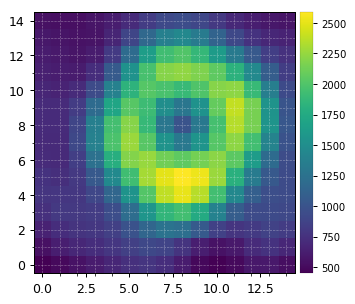

In [9]:
plots(vip.preproc.frame_crop(cube_orig[0], 15), grid=True)

For this ADI dataset we could use either a negative 2d Gaussian fit (assuming the dark hole corresponds with the position of the star) or a fourier cross-correlation based method (using more information including the bright donut and the speckles).

In [10]:
from vip_hci.preproc import cube_recenter_2dfit, cube_recenter_dft_upsampling

For the 2d Gaussian fit it's important to run the algorithm once with the `debug` parameter set to True in order to check the results of the 2d Gaussian fit. You may need to adjust the position of the center of the structure to be fitted and the `subi_size` (in pixels). When using the debug mode set `nproc` to 1 or the plots won't show up.

In [11]:
cube1, shy1, shx1 = cube_recenter_2dfit(cube_orig, (51, 51), fwhm_naco, nproc=1, subi_size=5, 
                                        model='gauss', negative=True, full_output=True, debug=False)

----------------------------------------------------------------------
Starting time: 2018-03-14 23:13:24
----------------------------------------------------------------------
2d Gauss-fitting, looping through frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Shifting the frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.531442
----------------------------------------------------------------------


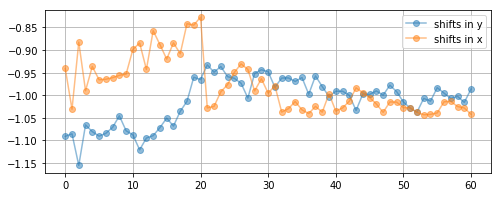

In [12]:
# 'Negative 2d Gaussian fit'
figure(figsize=(8,3))
plot(shy1, 'o-', label='shifts in y', alpha=0.5)
plot(shx1, 'o-', label='shifts in x', alpha=0.5)
legend(loc='best')
grid('on')

In [13]:
cube2, shy2, shx2 = cube_recenter_dft_upsampling(cube_orig, 51, 51, fwhm_naco, subi_size=5, full_output=True, 
                                                 debug=False)

----------------------------------------------------------------------
Starting time: 2018-03-14 23:13:25
----------------------------------------------------------------------
Shift for first frame X,Y=(-0.941, -1.091)
The rest of the frames will be shifted by cross-correlation wrt the first one
Looping through frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
Running time:  0:00:01.261574
----------------------------------------------------------------------


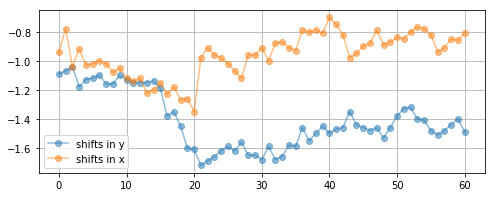

In [14]:
# 'Cross-correlation'
figure(figsize=(8,3))
plot(shy2, 'o-', label='shifts in y', alpha=0.5)
plot(shx2, 'o-', label='shifts in x', alpha=0.5)
legend(loc='best')
grid('on')

Frames re-centering is a case dependent procedure. For the purpose of this tutorial let's proceed with the results of the negative 2d Gaussian fit. Let's check the first frame again after the shift was applied:

In [15]:
cube = cube1

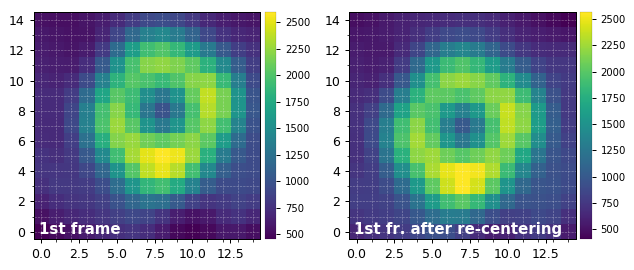

In [16]:
im1 = vip.preproc.frame_crop(cube_orig[0], 15, verbose=False)
im2 = vip.preproc.frame_crop(cube[0], 15, verbose=False)
plots(im1, im2, grid=True, label=['1st frame', '1st fr. after re-centering'])

For working with `VIP` the cubes must have been calibrated previously (dark/sky subtracted and flat-fielded).

For saving any results (1, 2 or 3d arrays) in FITS format use:

[Go to the top](#Table-of-contents)

## 2.2. Additional pre-processing procedures 

`preproc` also includes a few bad-pixel correction routines, several bad-frames detection functions as well as pixel upscaling routines. In `vip.var` are contained high and low pass filtering functions. We won't do any further pre-processing to our toy cube.

[Go to the top](#Table-of-contents)

# 3. Signal to noise and S/N map generation

Let's take a small de-tour for defining the S/N in high-contrast imaging (in the case of point-like sources). By default we adopt the definition of S/N given in Mawet el al. 2014, where it's proposed to use a two samples t-test for the problem of planet detection in the case of small sample statistics, which arise in high contrast imaging at small angles. 

The main idea is to test a given speckle against the background resolution elements (at the same angular separation or radial distance from the center):

$$S/N≡ \frac{\overline{x}_1 - \overline{x}_2}{s_2\sqrt{1+\frac{1}{n_2}}}􏰙,$$

where $\overline{x}_1$ is the flux of the tested resolution element (blue dot in the figure below), $\overline{x}_2$ and $s_2$ are the mean and empirical standard deviation of the fuxes of the background resolution elements (red dots in the figure below) and $n_2$ the number of such background resolution elements.

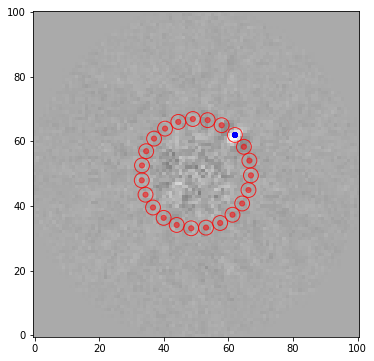

11.218246260747643

In [17]:
vip.phot.snr_ss(vip.pca.pca(cube, angs, ncomp=20, verbose=False), 
                source_xy=(62,62), fwhm=fwhm_naco, plot=True)

`VIP` also contains a function for estimating the S/N in a more classical way (without taking into account resolution elements but considering pixels as independent). In this case the S/N is taken as the ratio of pixel value of the planet (test speckle) and the noise computed as the standard deviation of the pixels in an annulus at the same radial distance from the center of the frame. The diameter of the signal aperture and the annulus width is in both cases 1 FWHM ~ 1 lambda/D.

In the ``phot`` subpackage we have also implemented a function for S/N map generation, by computing the S/N for each pixel of a 2D array. It has a parameter `nproc` for exploiting multi-core systems which by default is *None*, meaning that it will get the number of physical cores available in the system.

In case we really need the S/N map of a big frame (which can take quite some time to compute depending on your hardware), a good option is to use the function `snrmap_fast`. It uses an approximated S/N definition that yields close results to the one mentioned earlier. 

[Go to the top](#Table-of-contents)

# 4. Model PSF subtraction for ADI

In the framework of the differential imaging techniques, we ultimately rely on modelling and subtracting the post-coronagraphic star PSF and associated speckle noise pattern. Algorithms of different complexities and performances have been proposed in the last ~13 years. Several of those algorithms are implemented in ``VIP``.

## 4.1. ADI median subtraction

The most simple approach is to model the PSF with the median of the ADI sequence. The median subtraction algorithm is the original post-processing approach proposed for ADI data (see Marois et al. 2006):

In [18]:
fr_adi = vip.madi.adi(cube, angs, mode='fullfr')

----------------------------------------------------------------------
Starting time: 2018-03-14 23:13:27
----------------------------------------------------------------------
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.098475
----------------------------------------------------------------------


For the annular mode, using a parallactic angle threshold:

In [170]:
fr_adi_an = vip.madi.adi(cube, angs, fwhm_naco, asize=1, mode='annular', delta_rot=0.5, nframes=4)

----------------------------------------------------------------------
Starting time: 2018-03-15 00:52:00
----------------------------------------------------------------------
N annuli = 12 , FWHM = 4.6 

PA threshold 59.80 is too big, will be set to 36.61
Annulus 1, PA thresh = 36.61, Inn radius = 0.00, Ann center = 2.00, N segments = 1 
Annulus 2, PA thresh = 21.70, Inn radius = 4.00, Ann center = 6.00, N segments = 1 
Annulus 3, PA thresh = 13.12, Inn radius = 8.00, Ann center = 10.00, N segments = 1 
Annulus 4, PA thresh = 9.39, Inn radius = 12.00, Ann center = 14.00, N segments = 1 
Annulus 5, PA thresh = 7.31, Inn radius = 16.00, Ann center = 18.00, N segments = 1 
Annulus 6, PA thresh = 5.98, Inn radius = 20.00, Ann center = 22.00, N segments = 1 
Annulus 7, PA thresh = 5.07, Inn radius = 24.00, Ann center = 26.00, N segments = 1 
Annulus 8, PA thresh = 4.39, Inn radius = 28.00, Ann center = 30.00, N segments = 1 
Annulus 9, PA thresh = 3.87, Inn radius = 32.00, Ann center = 34

*b* is clearly visible in the final frames:

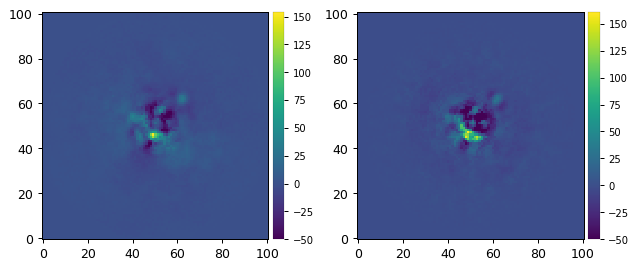

In [171]:
plots(fr_adi, fr_adi_an, vmin=-50, vmax=None)

[Go to the top](#Table-of-contents)

## 4.2. Pairwise frame differencing

Another simple approach is to perform pairwise frame subtraction, taking into account a rotation threshold. This is similar to the algorithm proposed by Hegelber et al 2015. This implementation can also impose a distance threshold (similarity)

In [153]:
fr_fdiff = vip.frdiff.frame_diff(cube, angs, fwhm_naco, metric='l1', dist_threshold=90, 
                                 delta_rot=0.2, radius_int=4, asize=4, nproc=1, verbose=True)

----------------------------------------------------------------------
Starting time: 2018-03-15 00:48:47
----------------------------------------------------------------------
11 annuli. Performing pair-wise subtraction:

Annulus 1, PA thresh = 8.77, Inn radius = 4.00, Ann center = 6.00, N segments = 1 
Running time:  0:00:00.229123
----------------------------------------------------------------------
Annulus 2, PA thresh = 5.27, Inn radius = 8.00, Ann center = 10.00, N segments = 1 
Running time:  0:00:00.174097
----------------------------------------------------------------------
Annulus 3, PA thresh = 3.76, Inn radius = 12.00, Ann center = 14.00, N segments = 1 
Running time:  0:00:00.175748
----------------------------------------------------------------------
Annulus 4, PA thresh = 2.93, Inn radius = 16.00, Ann center = 18.00, N segments = 1 
Running time:  0:00:00.176055
----------------------------------------------------------------------
Annulus 5, PA thresh = 2.40, Inn rad

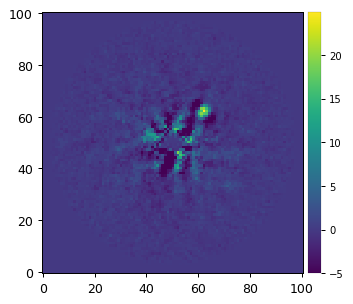

In [172]:
plots(fr_fdiff, vmin=-5)

[Go to the top](#Table-of-contents)

## 4.3. Least-squares approximation

A continuation of the idea of imposing a rotation/PA threshold was proposed by Lafreniere et al. 2007, but this time working in annular patches and using a more sophisticated model PSF. In this case the model PSF is built as a linear combination of the reamining frames (after discarding the close ones). 

In [236]:
fr_lstsq = vip.leastsq.xloci(cube, angs, fwhm_naco, asize=10, n_segments='auto', nproc=10, 
                             metric='correlation', dist_threshold=90, delta_rot=0.2, solver='lstsq', tol=0.01)

----------------------------------------------------------------------
Starting time: 2018-03-15 01:07:16
----------------------------------------------------------------------
5 annuli. Performing least-square combination and subtraction:

Annulus 1, PA thresh = 10.51, Inn radius = 0.00, Ann center = 5.00, N segments = 2 
Annulus 2, PA thresh = 3.51, Inn radius = 10.00, Ann center = 15.00, N segments = 3 
Annulus 3, PA thresh = 2.11, Inn radius = 20.00, Ann center = 25.00, N segments = 5 
Annulus 4, PA thresh = 1.51, Inn radius = 30.00, Ann center = 35.00, N segments = 7 
Annulus 5, PA thresh = 1.20, Inn radius = 39.00, Ann center = 44.00, N segments = 9 
Done processing annuli
Running time:  0:00:05.825249
----------------------------------------------------------------------


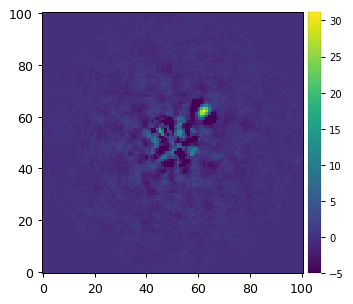

In [237]:
plots(fr_lstsq, vmin=-5)

[Go to the top](#Table-of-contents)

## 4.4. Full-frame PCA

Now let's try the PCA based algorithms (Amara & Quanz 2012, Soummer et al. 2012) in `vip.pca`:

In [179]:
fr_pca1 = vip.pca.pca(cube, angs, ncomp=4, mask_center_px=None)

----------------------------------------------------------------------
Starting time: 2018-03-15 00:55:44
----------------------------------------------------------------------
Done vectorizing the frames. Matrix shape [61,10201]
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.096260
----------------------------------------------------------------------
Done de-rotating and combining
Running time:  0:00:00.172156
----------------------------------------------------------------------


Here we compare the median subtraction with the PCA result (on the right). The improvement is clear:

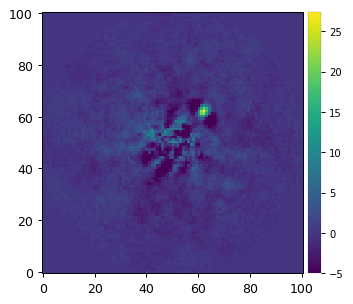

In [180]:
plots(fr_pca1, vmin=-5)

[Go to the top](#Table-of-contents)

### 4.4.1. Optimizing the number of PCs for full-frame ADI PCA

Clearly modeling the background (leaked starlight + static and quasi-static speckles) with PCA is better than the subtraction of the median frame. We chose 5 principal componenets (PCs) and we already improved the residual noise. 

With the function below we can find the optimal number of PCs for this position in the FOV:

----------------------------------------------------------------------
Starting time: 2018-03-14 23:13:28
----------------------------------------------------------------------
Done SVD/PCA with numpy SVD (LAPACK)
Number of evaluated steps 16
Optimal number of PCs = 17, for SNR=12.054 

Running time:  0:00:01.311825
----------------------------------------------------------------------

----------------------------------------------------------------------
Coords of chosen px (X,Y) = 62.000,62.000
Flux in a centered 1xFWHM circular aperture = 69.437
Central pixel S/N = 12.054
----------------------------------------------------------------------
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.529
Max S/N (shifting the aperture center) = 12.526
stddev S/N (shifting the aperture center) = 2.632
----------------------------------------------------------------------


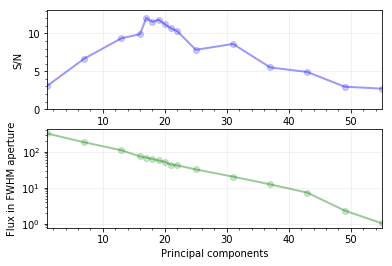

In [23]:
opt_pcs = vip.pca.pca_optimize_snr(cube, angs, fwhm=fwhm_naco, source_xy=(62,62), 
                                   mask_center_px=None, fmerit='px', 
                                   range_pcs=None)

Now let's use the 17 PCs and compute the S/N maps:

In [24]:
fr_pca2 = vip.pca.pca(cube, angs, ncomp=opt_pcs, mask_center_px=None)

----------------------------------------------------------------------
Starting time: 2018-03-14 23:13:30
----------------------------------------------------------------------
Done vectorizing the frames. Matrix shape [61,10201]
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.048742
----------------------------------------------------------------------
Done de-rotating and combining
Running time:  0:00:00.111826
----------------------------------------------------------------------


In [25]:
snrmap1 = vip.phot.snrmap(fr_pca1, fwhm_naco, plot=False)
snrmap2 = vip.phot.snrmap(fr_pca2, fwhm_naco, plot=False)

----------------------------------------------------------------------
Starting time: 2018-03-14 23:13:31
----------------------------------------------------------------------
S/N map created using 28 processes.
Running time:  0:00:01.335860
----------------------------------------------------------------------
----------------------------------------------------------------------
Starting time: 2018-03-14 23:13:32
----------------------------------------------------------------------
S/N map created using 28 processes.
Running time:  0:00:01.139403
----------------------------------------------------------------------


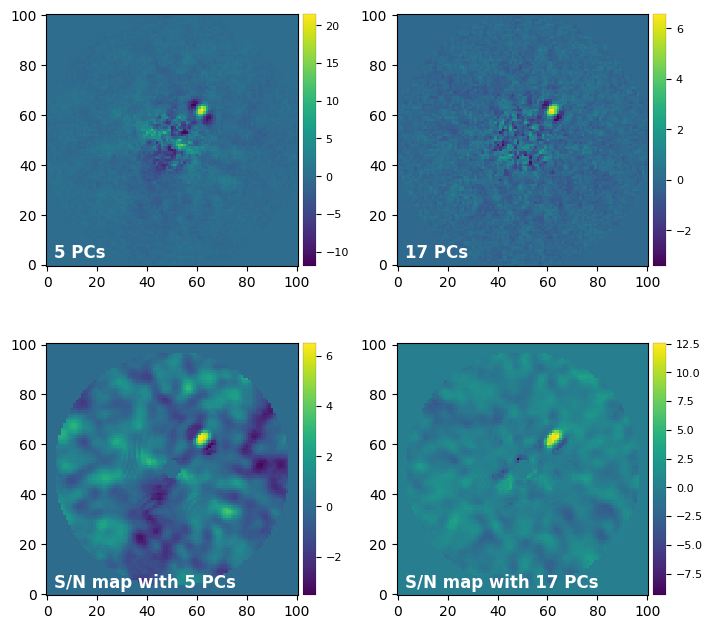

In [26]:
plots(fr_pca1, fr_pca2, snrmap1, snrmap2, rows=2, dpi=100, colorb=True, 
      label=['5 PCs', '17 PCs', 'S/N map with 5 PCs', 'S/N map with 17 PCs'], labelpad=8)

With 17 PCs we've increased the S/N but reduced also the flux from the companion.

[Go to the top](#Table-of-contents)

### 4.4.2. Full-frame ADI PCA with a PA rejection criterion

This dataset has a good range of rotation:

Text(0,0.5,'Parallactic angles')

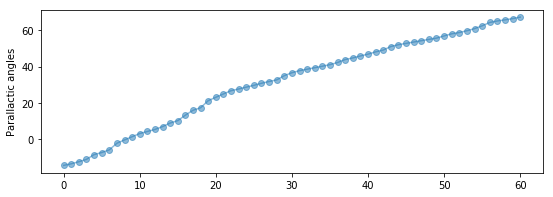

In [272]:
figure(figsize=(9,3))
plot(angs, 'o-', alpha=0.5)
ylabel('Parallactic angles')

We can partially avoid the companion self-subtraction with full-frame PCA by applying a PA threshold for a given distance from the center (exploiting the ~80 degrees of rotation). The PCA function in ``VIP`` accepts a parameter `source_xy` for defining this location and the corresponding PA threshold. The parameter `delta_rot` sets the amount of rotation in terms of the FWHM for rejecting frames from the library.

In [28]:
fr_pca_optlib = vip.pca.pca(cube, angs, ncomp=17, source_xy=(62,62), delta_rot=1, fwhm=fwhm_naco)

----------------------------------------------------------------------
Starting time: 2018-03-14 23:13:34
----------------------------------------------------------------------
Size LIB: min=30.0 / 1st QU=30.0 / med=30.0 / 3rd QU=30.0 / max=30.0
Done de-rotating and combining
Running time:  0:00:01.045733
----------------------------------------------------------------------


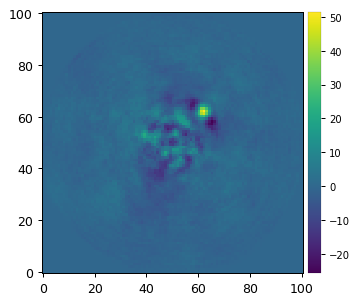

In [241]:
plots(fr_pca_optlib)

We can have a quick report on the frames by choosing a position with `source_xy`:

In [242]:
_ = vip.phot.frame_quick_report(fr_pca2, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coords of chosen px (X,Y) = 62.000,62.000
Flux in a centered 1xFWHM circular aperture = 69.437
Central pixel S/N = 12.054
----------------------------------------------------------------------
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.529
Max S/N (shifting the aperture center) = 12.526
stddev S/N (shifting the aperture center) = 2.632
----------------------------------------------------------------------


In [243]:
_ = vip.phot.frame_quick_report(fr_pca_optlib, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coords of chosen px (X,Y) = 62.000,62.000
Flux in a centered 1xFWHM circular aperture = 503.947
Central pixel S/N = 6.482
----------------------------------------------------------------------
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 4.772
Max S/N (shifting the aperture center) = 6.482
stddev S/N (shifting the aperture center) = 1.070
----------------------------------------------------------------------


Compared to the full-frame case, without a PA threshold, the companion flux is 7 times larger. The S/N has decreased due to the less smooth background at the same separation.

[Go to the top](#Table-of-contents)

### 4.4.3. PCA for big datacubes

Computing the PCA model can be a CPU and memory intensive procedure, when working with thousands of large (> 500x500) frames. This small toy cube won't let us demostrate this. In the `VIP` there will be more details about this. Check the function documentation:

[Go to the top](#Table-of-contents)

## 4.5. Annular PCA

We can exploit the range of rotation by using annular PCA approximations and applying a PA threshold for different annuli. This is the same idea used before but the PA threshold will be adjusted depending on the distance from the star. PCA can be computed in the whole annulus or in separate segments (``n_segments``). The computational cost increases accordingly.

The function `vip.pca.pca_adi_annular` processes the cube in annular fashion in a serial or parallel way. The improvement in speed is noticeable in multi-core machines.

In [32]:
from vip_hci.pca import pca_adi_annular

In [33]:
fr_pca_an15 = pca_adi_annular(cube, angs, fwhm=fwhm_naco, ncomp=15, asize=1, 
                              delta_rot=0.5, nproc=None, svd_mode='lapack')

----------------------------------------------------------------------
Starting time: 2018-03-14 23:13:36
----------------------------------------------------------------------
# annuli = 10, Ann width = 5, FWHM = 4.600 

PCA per annulus (or annular segment)

PA threshold 49.40 is too big, will be set to 36.61
Annulus 1, PA thresh = 36.61, Inn radius = 0.00, Ann center = 2.50, N segments = 1 
LIBsize: min=6.0 / 1st QU=11.0 / med=18.0 / 3rd QU=25.0 / max=41.0
Num PCs: min=6.0 / 1st QU=11.0 / med=15.0 / 3rd QU=15.0 / max=15.0
Done PCA with lapack for current annulus
Running time:  0:00:00.188940
----------------------------------------------------------------------
Annulus 2, PA thresh = 17.43, Inn radius = 5.00, Ann center = 7.50, N segments = 1 
LIBsize: min=28.0 / 1st QU=31.0 / med=37.0 / 3rd QU=43.0 / max=51.0
Num PCs: min=15.0 / 1st QU=15.0 / med=15.0 / 3rd QU=15.0 / max=15.0
Done PCA with lapack for current annulus
Running time:  0:00:00.892841
-------------------------------------

The parameter `ncomp` can be set to *None* for letting the algorithm define automatically the number of PCs for each patch (instead of fixing it for all of them) by minimizing the change in the standard deviation of the  residuals after the subtraction of the PCA approximation, when increasing the PCs. This procedure is somewhat similar to Least-squares/LOCI. Let's try this and use 3 segments per annulus:

In [244]:
fr_pca_auto = pca_adi_annular(cube, angs, fwhm=fwhm_naco, ncomp=None, svd_mode='lapack',
                              asize=2, delta_rot=0.5, n_segments=3, tol=0.1, verbose=True)

----------------------------------------------------------------------
Starting time: 2018-03-15 01:14:00
----------------------------------------------------------------------
# annuli = 5, Ann width = 10, FWHM = 4.600 

PCA per annulus (or annular segment)

Annulus 1, PA thresh = 25.91, Inn radius = 0.00, Ann center = 5.00, N segments = 3 
LIBsize: min=18.0 / 1st QU=22.0 / med=27.0 / 3rd QU=34.0 / max=45.0
Num PCs: min=18.0 / 1st QU=22.0 / med=25.0 / 3rd QU=27.0 / max=29.0
LIBsize: min=18.0 / 1st QU=22.0 / med=27.0 / 3rd QU=34.0 / max=45.0
Num PCs: min=18.0 / 1st QU=22.0 / med=25.0 / 3rd QU=26.0 / max=29.0
LIBsize: min=18.0 / 1st QU=22.0 / med=27.0 / 3rd QU=34.0 / max=45.0
Num PCs: min=18.0 / 1st QU=22.0 / med=25.0 / 3rd QU=27.0 / max=30.0
Done PCA with lapack for current annulus
Running time:  0:00:01.399635
----------------------------------------------------------------------
Annulus 2, PA thresh = 8.77, Inn radius = 10.00, Ann center = 15.00, N segments = 3 
LIBsize: min=43.0 / 1

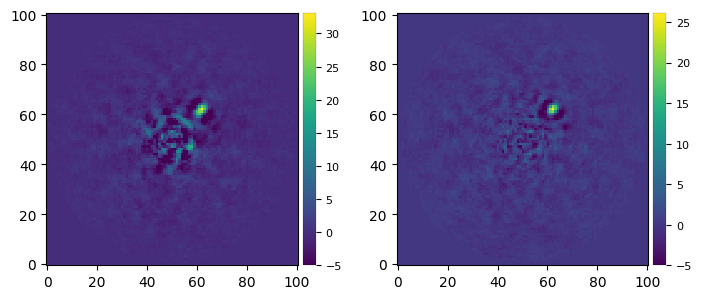

In [248]:
plots(fr_pca_an15, fr_pca_auto, dpi=100, vmin=-5, colorb=True)

In [246]:
_ = vip.phot.frame_quick_report(fr_pca_an15, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coords of chosen px (X,Y) = 62.000,62.000
Flux in a centered 1xFWHM circular aperture = 284.513
Central pixel S/N = 8.913
----------------------------------------------------------------------
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 7.163
Max S/N (shifting the aperture center) = 9.306
stddev S/N (shifting the aperture center) = 1.994
----------------------------------------------------------------------


In [249]:
_ = vip.phot.frame_quick_report(fr_pca_auto, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coords of chosen px (X,Y) = 62.000,62.000
Flux in a centered 1xFWHM circular aperture = 205.084
Central pixel S/N = 14.234
----------------------------------------------------------------------
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.182
Max S/N (shifting the aperture center) = 15.812
stddev S/N (shifting the aperture center) = 3.274
----------------------------------------------------------------------


[Go to the top](#Table-of-contents)

## 4.6. Full-frame ADI-NMF

A PSF reference can be modelled using a low-rank approximation different than the PCA one. Non-negative matrix factorization serves for such purpose. In `VIP's` paper there will be more details about it.

In [39]:
fr_nmf = vip.nmf.nmf(cube, angs, ncomp=20, max_iter=100, random_state=0, mask_center_px=None)

----------------------------------------------------------------------
Starting time: 2018-03-14 23:14:32
----------------------------------------------------------------------
Done vectorizing the frames. Matrix shape [61,10201]
Done NMF with sklearn.NMF.
Running time:  0:00:00.969576
----------------------------------------------------------------------
Done derotating and combining.
Running time:  0:00:01.293820
----------------------------------------------------------------------


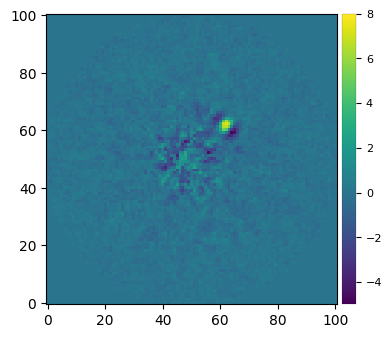

In [250]:
plots(fr_nmf, dpi=100, vmin=-5, vmax=8, colorb=True)

In [41]:
_ = vip.phot.frame_quick_report(fr_nmf, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coords of chosen px (X,Y) = 62.000,62.000
Flux in a centered 1xFWHM circular aperture = 73.539
Central pixel S/N = 9.204
----------------------------------------------------------------------
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 7.289
Max S/N (shifting the aperture center) = 9.204
stddev S/N (shifting the aperture center) = 1.721
----------------------------------------------------------------------


[Go to the top](#Table-of-contents)

## 4.7. LLSG

Local Low-rank plus Sparse plus Gaussian-noise decomposition (Gomez Gonzalez et al. 2016) proposes a three term decomposition for improving the detectability of point-like sources in ADI data. This first version of our algorithm aims at decomposing ADI cubes into L+S+G (low-rank, sparse and Gaussian noise) terms. Separating the noise from the S component (where the moving planet should stay) allow us to increase the S/N of potential planets.


Let's try it out:

In [42]:
fr_llsg = vip.llsg.llsg(cube, angs, fwhm_naco, rank=6, thresh=1, max_iter=20, random_seed=10)

----------------------------------------------------------------------
Starting time: 2018-03-14 23:14:34
----------------------------------------------------------------------
Annuli = 5
Processing annulus: 
1 : in_rad=0, n_segm=4
2 : in_rad=10, n_segm=4
3 : in_rad=20, n_segm=4
4 : in_rad=30, n_segm=4
5 : in_rad=40, n_segm=4

Running time:  0:00:02.868947
----------------------------------------------------------------------


Let's plot it along the full-frame ADI PCA result, after the optimization of the number of PCs:

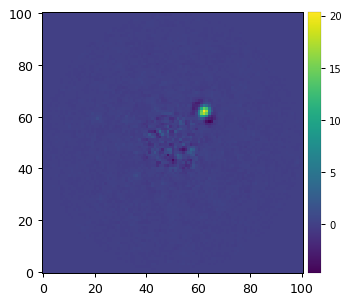

In [251]:
plots(fr_llsg)

In [44]:
_ = vip.phot.frame_quick_report(fr_llsg, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coords of chosen px (X,Y) = 62.000,62.000
Flux in a centered 1xFWHM circular aperture = 177.370
Central pixel S/N = 25.786
----------------------------------------------------------------------
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 25.021
Max S/N (shifting the aperture center) = 56.667
stddev S/N (shifting the aperture center) = 10.411
----------------------------------------------------------------------


A S/N map when the noise has been almost totally supressed becomes problematic, but nevertheless let's compute it:

----------------------------------------------------------------------
Starting time: 2018-03-14 23:14:38
----------------------------------------------------------------------


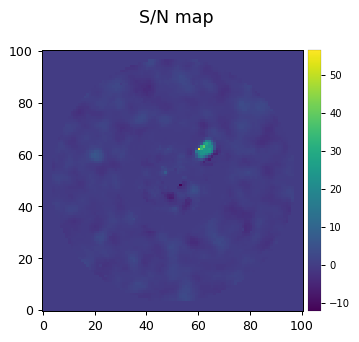

S/N map created using 28 processes.
Running time:  0:00:01.319345
----------------------------------------------------------------------


In [45]:
snrmap_llsg = vip.phot.snrmap(fr_llsg, fwhm_naco, plot=True)

[Go to the top](#Table-of-contents)

## 4.8. Mosaic with the ADI model PSF subtraction techniques so far

Let's take a look at the final residual frames produced by different algorithms:

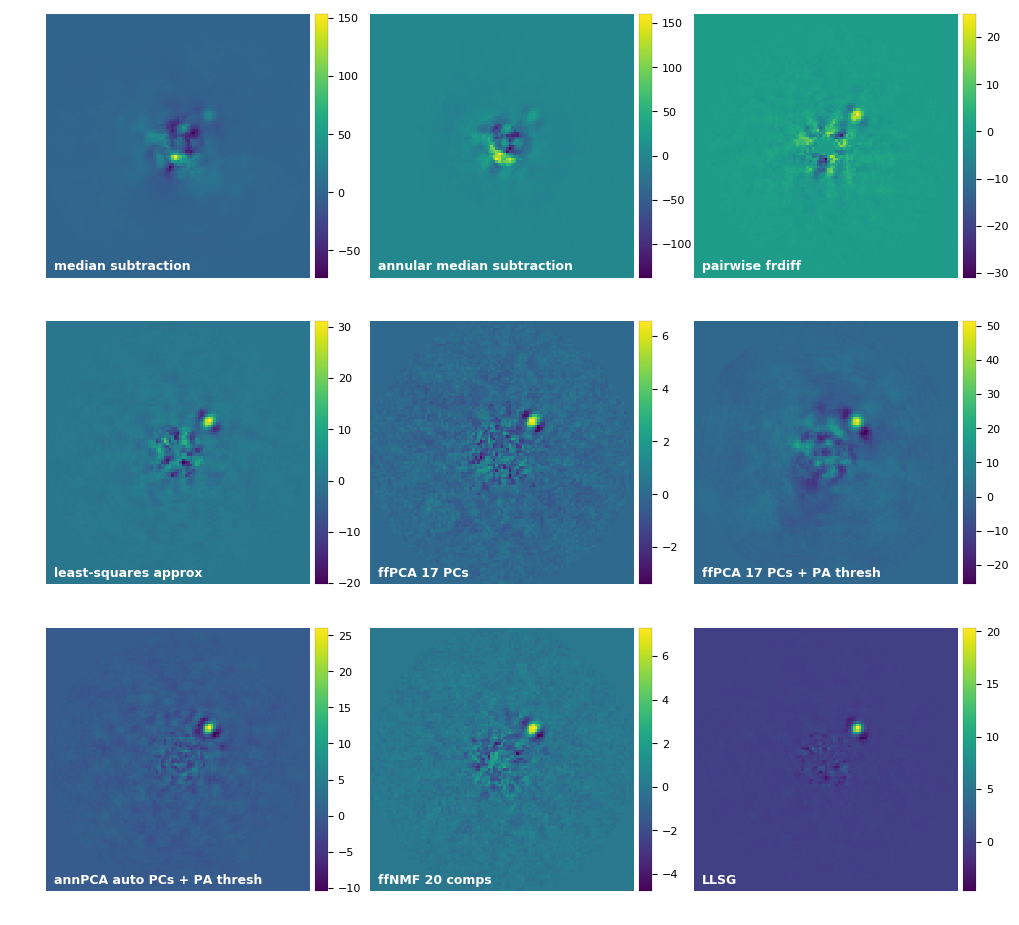

In [270]:
plots(fr_adi, fr_adi_an, fr_fdiff, fr_lstsq, fr_pca2, fr_pca_optlib, fr_pca_auto, fr_nmf, fr_llsg, 
      rows=3, dpi=100, colorb=True, labelsize=9, labelpad=8, axis=False, versp=0.05, horsp=0.15, 
      label=['median subtraction', 'annular median subtraction', 'pairwise frdiff', 'least-squares approx', 
             'ffPCA 17 PCs','ffPCA 17 PCs + PA thresh', 'annPCA auto PCs + PA thresh', 'ffNMF 20 comps', 'LLSG'])

[Go to the top](#Table-of-contents)

# 5. Detection function

Let's try the detection module, providing the processed frame, the FWHM in pixels and a PSF (what the planet should look like). Take a look at the help/docstring for an detailed explanation of the function. Depending on the `mode` the results can be different. As a final step a S/N minimum criterion can be checked, with `snr_thresh`.

We'll try a computer vision blob-detection method, the Laplacian of Gaussian filter (http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log) on the median subtracted frame and the annular PCA.

FWHM = 4.80 pxs

Blobs found: 4
 ycen   xcen
------ ------
71.943 	 71.869
63.326 	 51.183
54.716 	 59.849
55.023 	 52.975
----------------------------------------------------------------------
X,Y = (61.9,61.9)
S/N constraint NOT fulfilled (S/N = 2.233)
----------------------------------------------------------------------
X,Y = (41.2,53.3)
S/N constraint NOT fulfilled (S/N = 1.778)
----------------------------------------------------------------------
X,Y = (49.8,44.7)
S/N constraint NOT fulfilled (S/N = 2.766)
----------------------------------------------------------------------
X,Y = (43.0,45.0)
S/N constraint NOT fulfilled (S/N = 1.094)


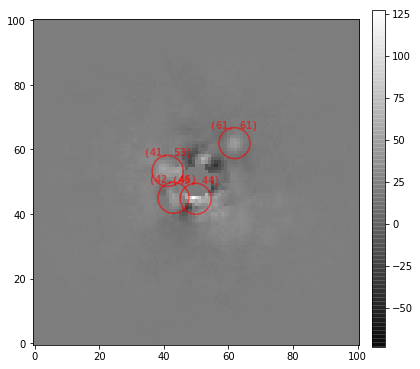

(array([], dtype=float64), array([], dtype=float64))

In [46]:
vip.phot.detection(fr_adi, psfn, debug=False, mode='log', snr_thresh=5, 
                   bkg_sigma=3, matched_filter=False)

Planet *b* is highlighted but with rather small S/N (~2). We can try the frame obtained with the annular PCA:

FWHM = 4.80 pxs

Blobs found: 3
 ycen   xcen
------ ------
71.986 	 71.943
67.556 	 63.753
55.914 	 66.498
----------------------------------------------------------------------
X,Y = (61.9,62.0)
----------------------------------------------------------------------
Coords of chosen px (X,Y) = 61.943,61.986
Flux in a centered 1xFWHM circular aperture = 213.237
Central pixel S/N = 15.199
----------------------------------------------------------------------
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.693
Max S/N (shifting the aperture center) = 16.873
stddev S/N (shifting the aperture center) = 3.451
----------------------------------------------------------------------
----------------------------------------------------------------------
X,Y = (53.8,57.6)
S/N constraint NOT fulfilled (S/N = 0.336)
----------------------------------------------------------------------
X,Y = (56.5,45.9)
S/N constraint NOT fulfilled (S/N = 1.873)


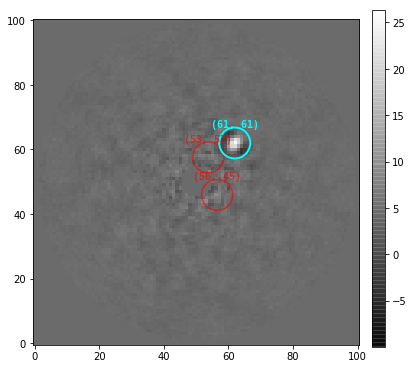

(array([61.9863324]), array([61.94300801]))

In [47]:
vip.phot.detection(fr_pca_quadan_auto, psfn, bkg_sigma=3, debug=False, mode='log', 
                   snr_thresh=5, plot=True, verbose=True)

[Go to the top](#Table-of-contents)

# 6. Generating synthetic planets

With `VIP` we can we can inject fake companions with an arbitrary flux using the normalized PSF. Other procedures, e.g. the negative fake companion technique and the contrast curve generation, rely on the injection of fake companions.

In [48]:
from vip_hci.phot import cube_inject_companions

In [49]:
cubefc = cube_inject_companions(cube, psfn, angs, flevel=400, plsc=pxscale_naco, 
                                rad_dists=[30.5], theta=240, n_branches=1)

Branch 1:
	(X,Y)=(34.75, 23.59) at 0.83 arcsec (30.50 pxs)


Let's optimize the S/N with full-frame ADI PCA at the position of the max pixel: 35,23 (found by looking at a reduced image on DS9):

----------------------------------------------------------------------
Starting time: 2018-03-14 23:14:40
----------------------------------------------------------------------
Done SVD/PCA with numpy SVD (LAPACK)
Number of evaluated steps 14
Optimal number of PCs = 15, for SNR=12.743 

Running time:  0:00:01.989102
----------------------------------------------------------------------

----------------------------------------------------------------------
Coords of chosen px (X,Y) = 35.000,23.000
Flux in a centered 1xFWHM circular aperture = 91.691
Central pixel S/N = 14.777
----------------------------------------------------------------------
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 12.743
Max S/N (shifting the aperture center) = 18.569
stddev S/N (shifting the aperture center) = 4.518
----------------------------------------------------------------------


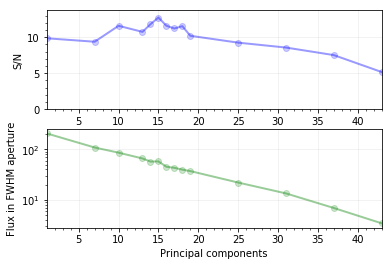

In [50]:
opt_pcs2 = vip.pca.pca_optimize_snr(cubefc, angs, fwhm=fwhm_naco, source_xy=(35,23), 
                                    mask_center_px=None, fmerit='mean', range_pcs=None)

In [51]:
fr_pca3 = vip.pca.pca(cubefc, angs, ncomp=opt_pcs2)

----------------------------------------------------------------------
Starting time: 2018-03-14 23:14:43
----------------------------------------------------------------------
Done vectorizing the frames. Matrix shape [61,10201]
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.062987
----------------------------------------------------------------------
Done de-rotating and combining
Running time:  0:00:00.154206
----------------------------------------------------------------------


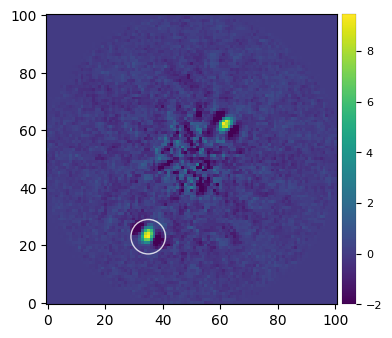

In [52]:
plots(fr_pca3, dpi=100, vmin=-2, colorb=True, circle=(35, 23))

In [53]:
_ = vip.phot.frame_quick_report(fr_pca3, fwhm=fwhm_naco, source_xy=(35,23))

----------------------------------------------------------------------
Coords of chosen px (X,Y) = 35.000,23.000
Flux in a centered 1xFWHM circular aperture = 91.691
Central pixel S/N = 14.777
----------------------------------------------------------------------
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 12.743
Max S/N (shifting the aperture center) = 18.569
stddev S/N (shifting the aperture center) = 4.518
----------------------------------------------------------------------


[Go to the top](#Table-of-contents)

# 7. Flux and position estimation with the NEGFC

`VIP` implement the Negative fake companion technique for point-like sources position and flux estimation. It follows this steps:


- Estimate the biased position and flux of the planet from the first reduced image.
- Use the measured off-axis PSF as a template to remove the first estimate from the cleaned data cube.
- Process the cube with PCA.
- Iterate on the position and flux until a well-chosen function of merit is minimized.  
        
$chi^2 = sum(|I_j|),$ where $j \in {1,...,N}$ and $N$ the total number of pixels contained in a circular aperture. We will take 3xFWHM for the aperture radius to make sure it fits inside the image.

[Go to the top](#Table-of-contents)

## 7.1. Nelder-Mead based optimization

With the funciton `vip.negfc.firstguess` we can obtain a first estimation of the flux and position by running a grid naive minimization and a Nelder-mead based minimization. Initially a naive minimization of the chi^2 by trying a grid of values for the flux (parameter `f_range`). If the parameter `simplex` is set to *True* then a Nelder-Mead (simplex) minimization is done based on the preliminary guess of the naive minimization. The maximum number of iterations and error can be set with the  parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

In [54]:
from vip_hci.negfc import firstguess

Fisrt we define the position of the sources by examining a flux frame or S/N map. `source_xy` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)). Let's take the (approximate) coordinates of the previously injected companion. Also, let's set the # of PCs to 20, which is higher than the optimal value (for full-frame PCA) and leads to a more aggresive reduction:

In [55]:
source_xy = [(35, 23)]
ncomp_fc = 20

----------------------------------------------------------------------
Starting time: 2018-03-14 23:14:44
----------------------------------------------------------------------

----------------------------------------------------------------------
             Planet 0           
----------------------------------------------------------------------

Planet 0: flux estimation at the position [35,23], running ...
Step | flux    | chi2r
1/100   0.000   0.243
2/100   50.505   0.234
3/100   101.010   0.221
4/100   151.515   0.211
5/100   202.020   0.200
6/100   252.525   0.194
7/100   303.030   0.187
8/100   353.535   0.186
9/100   404.040   0.187
10/100   454.545   0.191
11/100   505.051   0.207


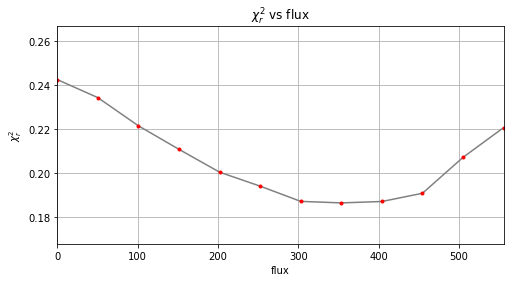

Planet 0: preliminary guess: (r, theta, f)=(30.9, 240.9, 353.5)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 74, nfev: 182, chi2r: 0.1347445548187691
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.619, 240.056, 358.064) at 
          (X,Y)=(34.72, 23.47)

 ---------------------------------------------------------------------- 
DONE !
 ----------------------------------------------------------------------
Running time:  0:00:22.053078
----------------------------------------------------------------------


In [56]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=ncomp_fc, plsc=pxscale_naco,
                               planets_xy_coord=source_xy, fwhm=fwhm_naco, 
                               f_range=None, annulus_width=3, aperture_radius=3,
                               simplex=True, display=True, verbose=True)

The Nelder-Mead optimization has found a (close-to-optimal) minimum. The estimated parameters are unfortunately not equal to the original values (radius=30.5, theta=240, flux=400), which reflects the limitations of this heuristic minization procedure (depending on the initial guess the minimization can get trapped in a different local minimum). Moreover, these are point estimates without uncertainties (error bars). We will come back to this questions later on.

[Go to the top](#Table-of-contents)

## 7.2. Planet subtraction

Let's use the values obtained with the simplex optimization at try to subtract the planet with the function `vip.negfc.cube_planet_free`.

In [57]:
from vip_hci.negfc import cube_planet_free

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [58]:
plpar_bpicb = [(r_0, theta_0, f_0)]

In [59]:
cube_emp = cube_planet_free(plpar_bpicb, cubefc, angs, psfn, pxscale_naco)

In [60]:
fr_pca_emp = vip.pca.pca(cube_emp, angs, ncomp=opt_pcs2, verbose=False)

Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

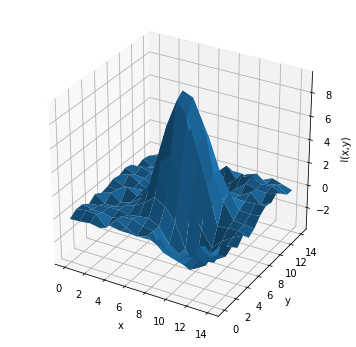

In [61]:
vip.var.plot_surface(fr_pca3, center_xy=(35, 23), size=15)

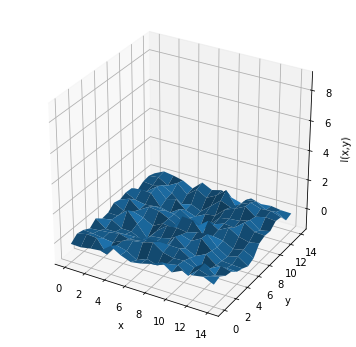

In [62]:
vip.var.plot_surface(fr_pca_emp, center_xy=(35, 23), size=15, zlim=(None, 9))

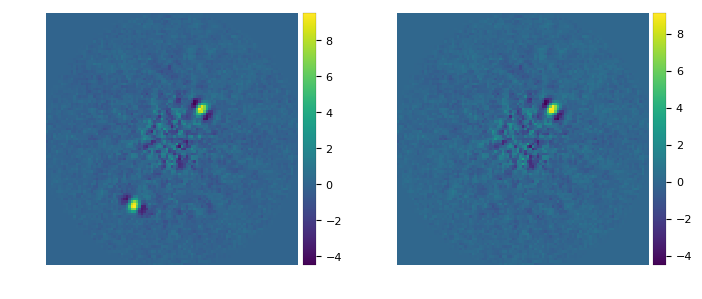

In [63]:
plots(fr_pca3, fr_pca_emp, dpi=100, axis=False)

Inspite of the understimated flux, the subtraction does not leave a noticeable artifact/defect.

[Go to the top](#Table-of-contents)

## 7.3. NEGFC technique coupled with MCMC

MCMC is a more robust way of obtaining the flux and position. It samples the posterior distributions of the parameters and from them we can generate proper error bars. With parameter ``initial_state`` we set the initial first estimation of the planets parameters (r, theta, flux). We can grabe the result of the simplex optimization.

In [64]:
from vip_hci.negfc import mcmc_negfc_sampling

In [68]:
init = np.array([30.619, 240.056, 358.064]) 

MCMC is a very CPU intensive procedure. We use the affine invariante sampler from `emcee` which can be run in parallel. At least 100 walkers are needed for convergence on our MCMC chain, but it's a case dependent parameter.

In [69]:
nwalkers, itermin, itermax = (100, 200, 500)

----------------------------------------------------------------------
Starting time: 2018-03-14 23:15:54
----------------------------------------------------------------------
        MCMC sampler for the NEGFC technique       
----------------------------------------------------------------------


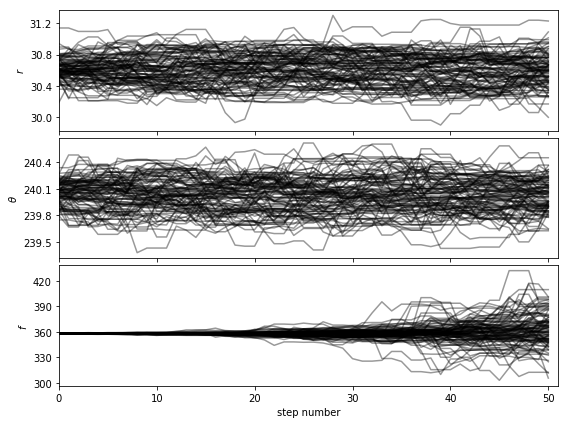

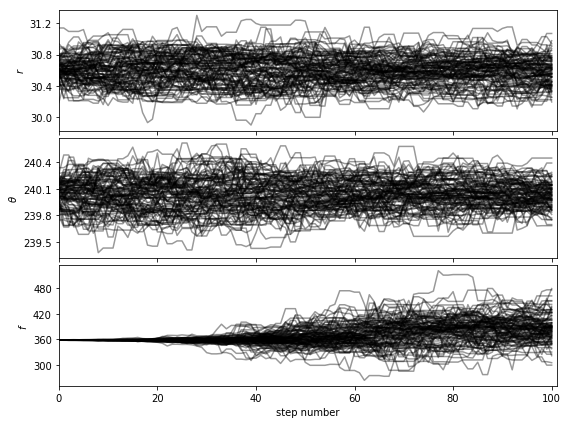

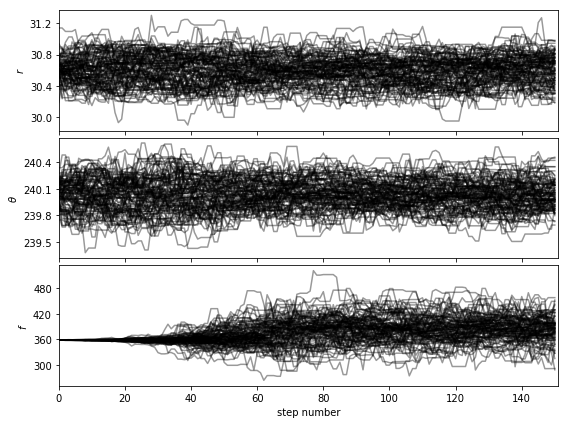

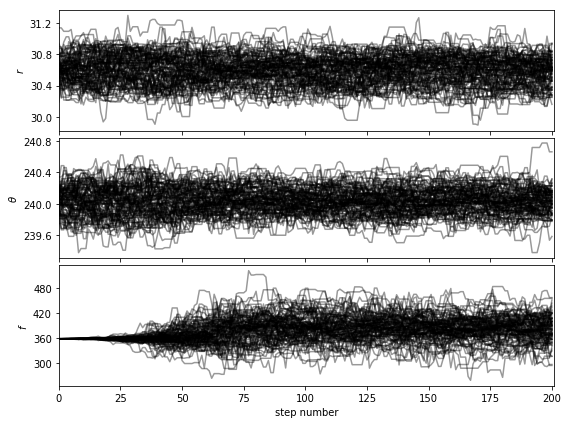

   r_hat = [1.00415119 1.00374326 1.00461943]
   r_hat <= threshold = [ True  True  True] 

... ==> convergence reached
We break the loop because we have reached convergence
Running time:  0:21:37.007073
----------------------------------------------------------------------


In [70]:
chain = mcmc_negfc_sampling(cubefc, angs, psfn, ncomp=ncomp_fc, plsc=pxscale_naco,                                
                            fwhm=fwhm_naco, svd_mode='lapack', annulus_width=3, 
                            aperture_radius=3, initial_state=init, nwalkers=nwalkers, 
                            bounds=None, niteration_min=itermin, rhat_count_threshold=1,
                            niteration_limit=itermax, check_maxgap=50, nproc=20,
                            display=True, verbosity=1, save=False)

Saved results, can be loaded from disk like this:

[Go to the top](#Table-of-contents)

### 7.3.1. Visualizing the MCMC chain: corner plots and walk plots 

Due to the small number of walkers and iterations convergence was not achieved.

In [71]:
from vip_hci.negfc import show_corner_plot, show_walk_plot

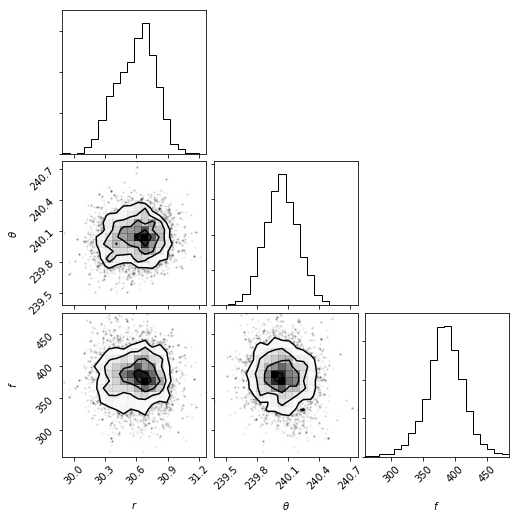

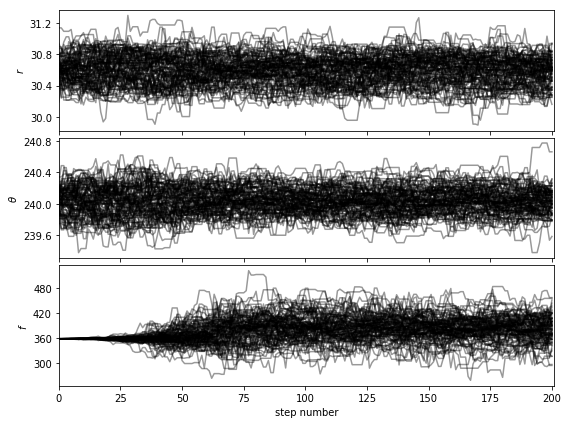

In [72]:
show_corner_plot(chain)
show_walk_plot(chain)

[Go to the top](#Table-of-contents)

### 7.3.2. Highly probable values and confidence intervals 

For determining the most highly probable value for each model parameter, as well as the 1-sigma confidence interval:

percentage for r: 69.48226950354612%
percentage for theta: 69.70921985815603%
percentage for flux: 69.68794326241135%


Confidence intervals:
r: 30.67055933292905 [-0.2821393746500398,0.1307475150817261]
theta: 239.99866533229192 [-0.1601776469700269,0.1880346290517707]
flux: 386.10415866046395 [-30.302214874376773,27.667239667909257]

Gaussian fit results:
r: 30.594695369471484 +-0.18326400602191925
theta: 240.0397534824626 +-0.1612041360058565
f: 382.9752887205708 +-30.15118978071996


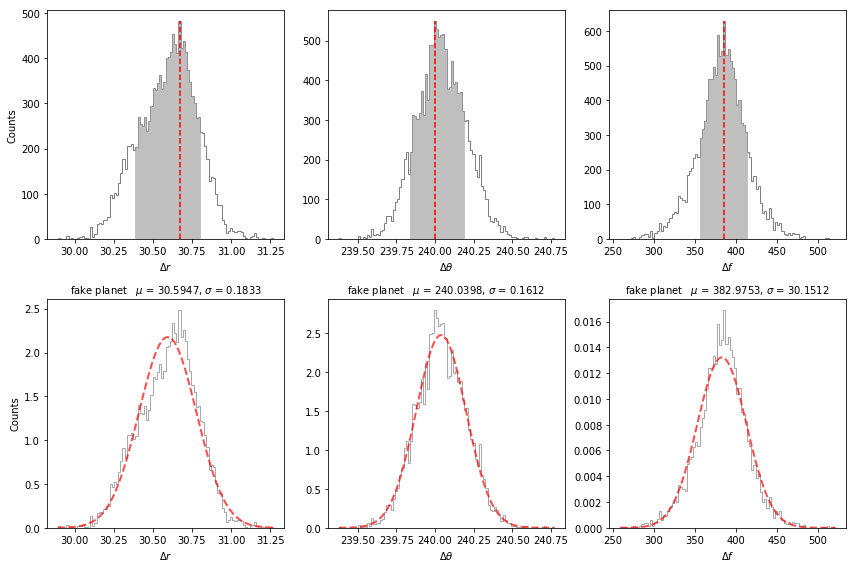

In [96]:
from vip_hci.negfc import confidence

burnin = 0.3
isamples_flat = chain[:, int(chain.shape[1]//(1/burnin)):, :].reshape((-1,3))

val_max, conf = confidence(isamples_flat, cfd=68, gaussian_fit=True, 
                           verbose=True, save=False, title='fake planet')

The mean and sigma of the posterior distributions of the estimated parameters give us the parameter and its error bar. We can see that, with the MCMC approach, the mean flux value is closer to the true value. Also the true value lies within the 1-sigma error bars. Perhaps with a longer chain (for example setting ``rhat_count_threshold`` to 3) we could obtain even better results.

[Go to the top](#Table-of-contents)

# 8. Algorithmic throughput

`VIP` allows to measure the throughput of its algorithms by injectin fake companions. That will give us an idea of how much they subtract or bias the signal from companions as a function of the distance from the center. We'll use `vip.phot.throughput`. This function requires an empty cube, for avoiding messing up with the throughput curve (due to the presence of a companion). 

First, let's create a cube without the real companion (beta Pic b):

In [112]:
cube_emp = cube_planet_free([(16.583, 44.721, 700)], cube, angs, psfn, pxscale_naco)

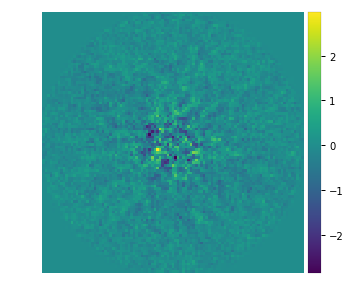

In [123]:
plots(vip.pca.pca(cube_emp, angs, ncomp=20, verbose=False), axis=False)

In [124]:
res_thr = vip.phot.throughput(cube_emp, angs, psfn, fwhm_naco, pxscale_naco, 
                              ncomp=15, algo=vip.pca.pca, nbranch=1, full_output=True)

----------------------------------------------------------------------
Starting time: 2018-03-15 00:20:49
----------------------------------------------------------------------
Cube without fake companions processed with pca
Running time:  0:00:00.143988
----------------------------------------------------------------------
Measured annulus-wise noise in resulting frame
Running time:  0:00:00.174457
----------------------------------------------------------------------
Fake companions injected in branch 1 (pattern 1/3)
Running time:  0:00:00.323778
----------------------------------------------------------------------
Cube with fake companions processed with pca
Measuring its annulus-wise throughput
Running time:  0:00:00.422811
----------------------------------------------------------------------
Fake companions injected in branch 1 (pattern 2/3)
Running time:  0:00:00.552948
----------------------------------------------------------------------
Cube with fake companions processed wi

Text(0.5,0,'separation in pixels')

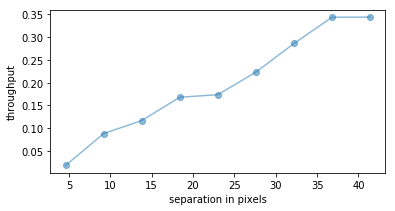

In [125]:
figure(figsize=(6,3))
plot(res_thr[2], res_thr[0][0,:], 'o-', alpha=0.5)
ylabel('throughput')
xlabel('separation in pixels')

Let's compare this with the annular PCA result:

In [126]:
res_thr2 = vip.phot.throughput(cube_emp, angs, psfn, fwhm_naco, pxscale_naco, 
                               algo=vip.pca.pca_adi_annular, nbranch=1, verbose=False,
                               full_output=True, ncomp=15, delta_rot=0.5, 
                               svd_mode='lapack', asize=2)

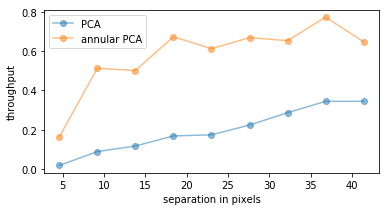

In [127]:
figure(figsize=(6,3))
plot(res_thr[2], res_thr[0][0,:], 'o-', label='PCA', alpha=0.5)
plot(res_thr2[2], res_thr2[0][0,:], 'o-', label='annular PCA', alpha=0.5)
ylabel('throughput')
xlabel('separation in pixels')
legend(loc='best')

We clearly see the gain in throughput by applying a parallactic angle rejection in our annular PCA processing. Here the `delta_rot` or amount of minimum rotation was decreased due the small number of frames, but increasing it to 1 or 1.5 (with a non temporally sub-sampled cube) will lead to better throughput.

[Go to the top](#Table-of-contents)

# 9. Contrast curve generation for ADI

Now let's see how to generate 5-sigma contrast curves for ADI data using `vip.phot.contrast_curve`. ``algo`` takes any function in ``VIP`` for model PSF subtraction. In the example below, we'll use full-frame PCA. Parameter `starphot` sets the flux of the star: aperture photometry of the off-axis or non-coronagraphic star PSF (we measured it on the unnormalized PSF image).

In [129]:
starphot = 764939.6

----------------------------------------------------------------------
Starting time: 2018-03-15 00:23:14
----------------------------------------------------------------------
ALGO : pca, FWHM = 4.6, # BRANCHES = 1, SIGMA = 5, STARPHOT = 764939.6
----------------------------------------------------------------------
Finished the throughput calculation
Running time:  0:00:00.967284
----------------------------------------------------------------------


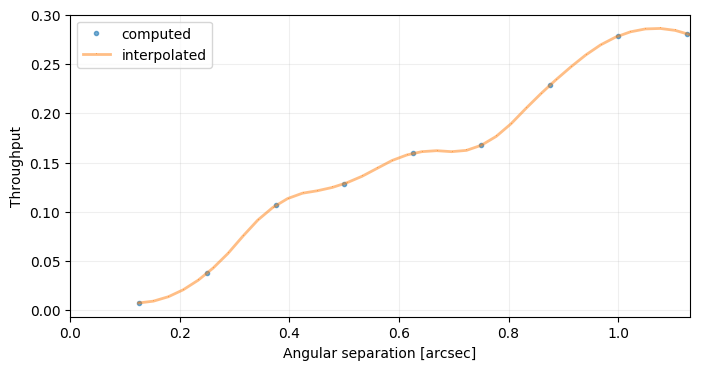

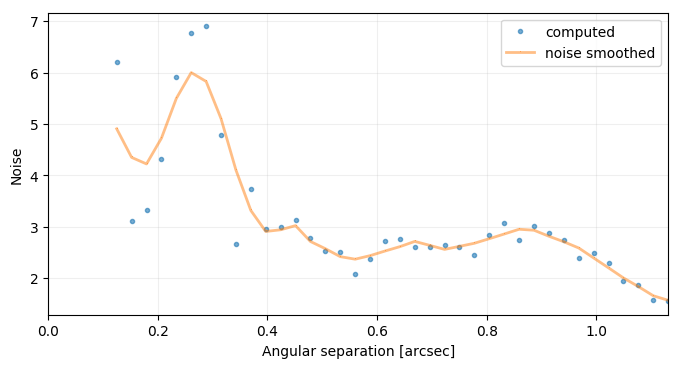

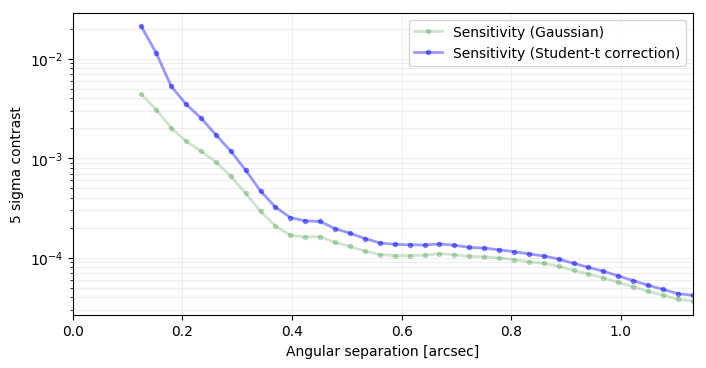

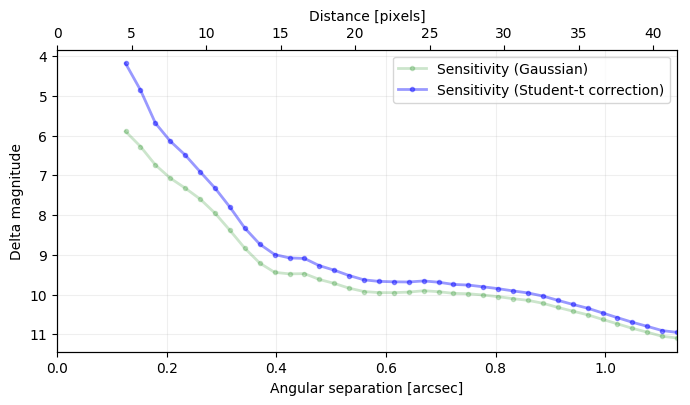

In [130]:
_ = vip.phot.contrast_curve(cube_emp, angs, psfn, fwhm_naco, pxscale_naco, starphot, 
                            sigma=5, nbranch=1, algo=vip.pca.pca, ncomp=opt_pcs, debug=True)

[Go to the top](#Table-of-contents)